# Autoreject and Spike Analysis

Here, we run autoreject on the final ICA preprocessed data and then perform Spike analysis.

In [1]:
# comment if you don't have nb_black installed
%load_ext lab_black

In [83]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys

warnings.filterwarnings("ignore")

import mne
from mne import make_fixed_length_epochs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids
import autoreject
from autoreject import AutoReject, read_auto_reject

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
    LeaveOneGroupOut,
)
from sklearn.utils import resample
import sklearn
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.io.read import load_persyst_spikes
from episcalp.utils.utils import NumpyEncoder

# if you installed sporf via README
from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Data Directories

In [23]:
jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

# not ready yet
upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [24]:
jh_ica_root = jhroot / "derivatives" / "ICA" / "1-30Hz-30" / "win-20"
jeff_ica_root = jeffroot / "derivatives" / "ICA" / "1-30Hz-30" / "win-20"

In [54]:
# read in spike dataframe
jh_spike_dataset = load_persyst_spikes(jhroot)
# jeff_spike_dataset = load_persyst_spikes(jeffroot)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']


In [57]:
display(jh_spike_dataset["data"][0])

,onset,duration,description,sample,ch_name,perception,height,n_secs
0,332.0,0.130,Spike T5-Av12 perception:0.11 height:56,66400,T5,0.11,56,981.0
1,490.0,0.125,Spike T6-Av12 perception:0.13 height:57,98000,T6,0.13,57,981.0
2,554.0,0.135,Spike F7-Av12 perception:0.11 height:46,110800,F7,0.11,46,981.0


In [71]:
display(data.head())

,onset,duration,description,sample,ch_name,perception,height,n_secs,epoch_idx
0,332.0,0.130,Spike T5-Av12 perception:0.11 height:56,66400,T5,0.11,56,981.0,332
1,490.0,0.125,Spike T6-Av12 perception:0.13 height:57,98000,T6,0.13,57,981.0,490
2,554.0,0.135,Spike F7-Av12 perception:0.11 height:46,110800,F7,0.11,46,981.0,554


In [78]:
data = jh_spike_dataset["data"][0]

# get spikes not in bad epochs
bad_epochs = reject_log.bad_epochs
bad_epoch_idx = np.argwhere(bad_epochs)
n_secs = data["n_secs"][0]

events = mne.make_fixed_length_events(
    raw, id=1, start=0, stop=None, duration=1.0, first_samp=True, overlap=0.0
)
assert len(events) == len(bad_epochs)

# mark all spikes in bad epochs
data["epoch_idx"] = None
data["bad_epoch"] = None

for idx, sample in enumerate(data["sample"]):
    lower_idx = np.argwhere(sample <= events[:, 0])[0]
    higher_idx = np.argwhere(sample >= events[:, 0])[-1]
    epoch_idx = higher_idx[0]
    data["epoch_idx"][idx] = epoch_idx

    in_bad_epoch = epoch_idx in bad_epoch_idx

    data["bad_epoch"][idx] = in_bad_epoch

display(data)

,onset,duration,description,sample,ch_name,perception,height,n_secs,epoch_idx,bad_epoch
0,332.0,0.130,Spike T5-Av12 perception:0.11 height:56,66400,T5,0.11,56,981.0,332,True
1,490.0,0.125,Spike T6-Av12 perception:0.13 height:57,98000,T6,0.13,57,981.0,490,False
2,554.0,0.135,Spike F7-Av12 perception:0.11 height:46,110800,F7,0.11,46,981.0,554,True


In [82]:
data.to_excel("~/Downloads/example.xlsx")

# Run Autoreject and Filter out 

In [28]:
ar = AutoReject(n_interpolate=[0])

In [31]:
subjects = jh_spike_dataset["subject"]

for idx in range(len(subjects)):
    subject = subjects[idx]
    bids_path = jh_spike_dataset["bids_path"][idx]
    bids_path.update(root=jh_ica_root)

    # read in that file
    raw = read_raw_bids(bids_path)
    raw.set_montage("standard_1020")

    # make these into epochs
    epochs = make_fixed_length_epochs(raw, duration=1)
    epochs.load_data()

    ar.fit(epochs)
    _, reject_log = ar.transform(epochs, return_log=True)

    
    
    break

Running autoreject on ch_type=eeg




Estimated consensus=0.60 and n_interpolate=0


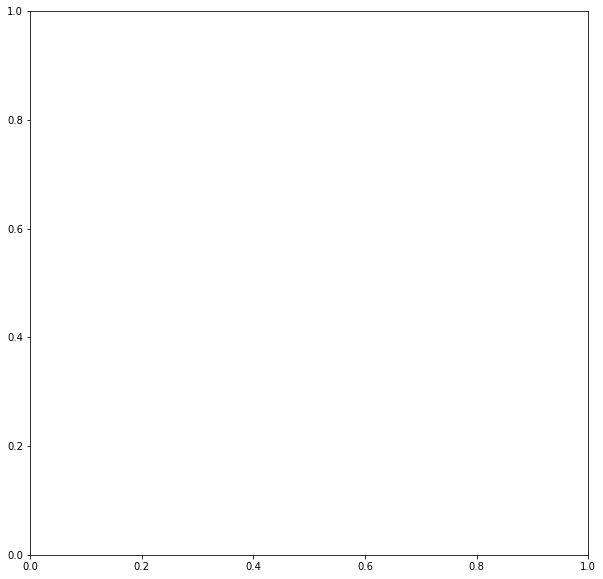

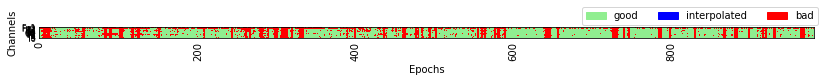

done


In [34]:
reject_log.plot("horizontal", show=True)
print("done")

In [42]:
print(reject_log.labels.shape)
print(ar.consensus_)
print(ar.threshes_)

(981, 14)
{'eeg': 0.6000000000000001}
{'Fp1': 4.5367972045045314e-05, 'Fp2': 4.3753425824459453e-05, 'F3': 2.907251457258827e-05, 'F4': 3.5960510599631045e-05, 'P3': 4.798876476332896e-05, 'P4': 3.342824909913726e-05, 'O1': 6.792141444400521e-05, 'O2': 8.750012390514847e-05, 'F7': 4.888637241737113e-05, 'F8': 4.433738547929319e-05, 'T3': 4.46421288186285e-05, 'T4': 4.042004837183751e-05, 'T5': 5.720309518723105e-05, 'T6': 5.567145815909622e-05}


In [40]:
# print(reject_log.bad_epochs)

[False False False False  True False  True False False  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True  True
 False False False False  True  True False False False False False False
 False False False False False  True False  True  True False False False
 False False False False False False False False False  True False False
 False False False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False Fa

In [50]:
ar_bids_path = bids_path.copy().update(
    check=False,
    processing="autoreject",
    extension=".h5",
    suffix="eeg",
)
print(ar_bids_path)
ar.save(fname=ar_bids_path)

/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/ICA/1-30Hz-30/win-20/sub-jhh001/eeg/sub-jhh001_run-01_proc-autoreject_eeg.h5


In [94]:
print(ar.consensus_)
ar.consensus = 0.8

{'eeg': 0.6000000000000001}


In [90]:
ar = read_auto_reject(ar_bids_path)

# read in that file
raw = read_raw_bids(bids_path)
raw.set_montage("standard_1020")

# make these into epochs
epochs = make_fixed_length_epochs(raw, duration=1)
epochs.load_data()

reject_log = ar.get_reject_log(epochs)
print(reject_log)
print(reject_log.bad_epochs)

In [91]:
print(reject_log.bad_epochs)

[False False False False  True False  True False False  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True  True
 False False False False  True  True False False False False False False
 False False False False False  True False  True  True False False False
 False False False False False False False False False  True False False
 False False False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False Fa